In [26]:
freq_spw = '259_spw47'

In [27]:
## Script for comparing data spectra to model spectra with lots of individual molecules

## Import statements
import sys
# For parallelization, which helps to make convolution faster
import dask
dask.config.set(scheduler = 'threads', num_workers = 8)
from dask.diagnostics import ProgressBar

import warnings
warnings.filterwarnings('ignore')
from astropy import units as u
from spectral_cube import SpectralCube
from astropy import coordinates
from astropy import wcs, log
import matplotlib.pyplot as plt
import numpy as np
import os
import io
from contextlib import redirect_stdout
import glob
from astropy.stats import mad_std
import regions

# ## Grab spectral window from command line arguments
# freq_spw = sys.argv[1] # Will be a string; e.g. 87_spw25
# if len(sys.argv) > 2:
#     progressbar = sys.argv[2] == "True"
# else:
#     progressbar = False
    
# if progressbar:
#     ProgressBar().register()

## Define variables
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
tkin = 151 # This needs to be changed if its value in the molfit files changes (TODO: GRAB THIS FROM FITTING RESULTS)
Ntot = 5.0e+13 # This needs to be changed if its value in the molfit files changes (TODO: GRAB THIS FROM FITTING RESULTS)

## Set up some matplotlib settings
SM_SIZE = 16
MD_SIZE = 20
LG_SIZE = 24
plt.rc('font', size = MD_SIZE)          # Controls default text sizes
plt.rc('axes', titlesize = LG_SIZE)     # Fontsize of the axes title
plt.rc('axes', labelsize = MD_SIZE)     # Fontsize of the x and y labels
plt.rc('xtick', labelsize = MD_SIZE)    # Fontsize of the tick labels
plt.rc('ytick', labelsize = MD_SIZE)    # Fontsize of the tick labels
plt.rc('legend', fontsize = SM_SIZE)    # Legend fontsize
plt.rc('figure', titlesize = LG_SIZE)   # Fontsize of the figure title
plt.rcParams.update({
    "figure.facecolor":  'none',
    "axes.facecolor":    'w',
    "savefig.facecolor": 'none'
})
# # Set up color and linestyle cycler
# from cycler import cycler
# plt.rc('axes', prop_cycle=(cycler('color', ['xkcd:azure', 'xkcd:orange', 'xkcd:teal', 'xkcd:magenta']) * cycler('linestyle', ['--', ':', '-.', (0,(3,1,1,1,1,1))])))
# User-maintained color list
colors = {'13CO;v=0;'   : ['tab:blue',   '--'],
          'CCCS;v=0;'   : ['tab:orange', '--'],
          'CCH;v=0;'    : ['tab:green',  '--'],
          'CCS;v=0;'    : ['tab:red',    '--'],
          'CH3CN;v=0;'  : ['tab:purple', '--'],
          'CH3OH;v=0;'  : ['tab:pink',   '--'],
          'CO;v=0;'     : ['tab:olive',  '--'],
          'H2CS;v=0;'   : ['tab:cyan',   '--'],
          'HC3N;v=0;'   : ['tab:blue',   '-.'],
          'HCN;v=0;'    : ['tab:orange', '-.'],
          'HCO+;v=0;'   : ['tab:green',  '-.'],
          'HDCO;v=0;'   : ['tab:red',    '-.'],
          'HNCO;v=0;'   : ['tab:purple', '-.'],
          'HNC;v=0;'    : ['tab:pink',   '-.'],
          'HOCO+;v=0;'  : ['tab:olive',  '-.'],
          'N2H+;v=0;'   : ['tab:cyan',   '-.'],
          'NH2D;v=0;'   : ['tab:blue',   ':'],
          'NH3;v=0;'    : ['tab:orange', ':'],
          'OCS;v=0;'    : ['tab:green',  ':'],
          'C17O;v=0;'   : ['tab:red',    ':'],
          'H13CO+;v=0;' : ['tab:purple', ':'],
          '13CO;v=0;'   : ['tab:pink',   ':'],
          'HC15N;v=0;'  : ['tab:olive',  ':'],
          'HN13C;v=0;'  : ['tab:cyan',   ':'],
          'C18O;v=0;'   : ['tab:blue',   (0,(3,1,1,1,1,1))],
          'H2COH+;v=0;' : ['tab:orange', (0,(3,1,1,1,1,1))],
          'NH2CHO;v=0;' : ['tab:green',  (0,(3,1,1,1,1,1))],
          'H13CN;v=0;'  : ['tab:red',    (0,(3,1,1,1,1,1))],
         }

## Set up XCLASS
XCLASSRootDir = str(os.environ.get('XCLASSRootDir', '')).strip()
XCLASSRootDir = os.path.normpath(XCLASSRootDir) + "/"
# Extend sys.path variable
NewPath = XCLASSRootDir + "build_tasks/"
if (not NewPath in sys.path):
    sys.path.append(NewPath)
import task_myXCLASS # I think this may need to stay here

# Define path and name of molfit file
# DEFAULT MolfitsFileName = LocalPath + "files/my_molecules.molfit"
LocalPath = os.getcwd() + "/"

# define freq. step (in MHz)
FreqStep = 0.1
# interferometric data?
Inter_Flag = True
# define red shift
Redshift = None
# BACKGROUND: describe continuum with tBack and tslope only
t_back_flag = True
# BACKGROUND: define background temperature (in K)
tBack = 0.0
# BACKGROUND: define temperature slope (dimensionless)
tslope = 0.0
# BACKGROUND: define path and name of ASCII file describing continuum as function
#             of frequency
BackgroundFileName = ""
# DUST: define hydrogen column density (in cm^(-2))
N_H = 1.e22
# DUST: define spectral index for dust (dimensionless)
beta_dust = 0.0
# DUST: define kappa at 1.3 mm (cm^(2) g^(-1))
kappa_1300 = 0.0
# DUST: define path and name of ASCII file describing dust opacity as
#       function of frequency
DustFileName = ""
# FREE-FREE: define electronic temperature (in K)
Te_ff = None
# FREE-FREE: define emission measure (in pc cm^(-6))
EM_ff = None
# SYNCHROTRON: define kappa of energy spectrum of electrons (electrons m^(−3) GeV^(-1))
kappa_sync = None
# SYNCHROTRON: define magnetic field (in Gauss)
B_sync = None
# SYNCHROTRON: energy spectral index (dimensionless)
p_sync = None
# SYNCHROTRON: thickness of slab (in AU)
l_sync = None
# PHEN-CONT: define phenomenological function which is used to describe
#            the continuum
ContPhenFuncID = None
# PHEN-CONT: define first parameter for phenomenological function
ContPhenFuncParam1 = None
# PHEN-CONT: define second parameter for phenomenological function
ContPhenFuncParam2 = None
# PHEN-CONT: define third parameter for phenomenological function
ContPhenFuncParam3 = None
# PHEN-CONT: define fourth parameter for phenomenological function
ContPhenFuncParam4 = None
# PHEN-CONT: define fifth parameter for phenomenological function
ContPhenFuncParam5 = None
# use iso ratio file?
iso_flag = True
# define path and name of iso ratio file
#DEFAULT IsoTableFileName = LocalPath + "files/my_isonames.txt"
IsoTableFileName = LocalPath + "my_isonames.txt"
# define path and name of file describing Non-LTE parameters
CollisionFileName = ""
# define number of pixels in x-direction (used for sub-beam description)
NumModelPixelXX = 100
# define number of pixels in y-direction (used for sub-beam description)
NumModelPixelYY = 100
# take local-overlap into account or not
LocalOverlapFlag = False
# disable sub-beam description
NoSubBeamFlag = True
# define path and name of database file
dbFilename = ""
# define rest freq. (in MHz)
RestFreq = 0.0
# define v_lsr (in km/s)
vLSR = 0.0

## Function definitions
def import_and_smooth_cube(freq_spw):
    basefn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
    if os.path.exists(basefn+".commonbeam.fits"):
        smoothed_cube = SpectralCube.read(basefn+".commonbeam.fits", use_dask = True)
        if smoothed_cube.max() == 0:
            # Remove cached "bad" version of smoothed cube, and resave
            os.remove(basefn+".commonbeam.fits")
            log.info(f"Re-smoothing cube {basefn}")
            cube = SpectralCube.read(basefn, use_dask = True)
            # Convert cube to a common beam
            cube_common_beam = cube.beams.common_beam(max_iter = 20, max_epsilon = 0.01)
            smoothed_cube = cube.convolve_to(cube_common_beam) # Convert from VaryingResolution to regular
            smoothed_cube.write(basefn+".commonbeam.fits")
    else:
        log.info(f"Smoothing cube {basefn}")
        cube = SpectralCube.read(basefn, use_dask = True)
        # Convert cube to a common beam
        cube_common_beam = cube.beams.common_beam(max_iter = 20, max_epsilon = 0.01)
        smoothed_cube = cube.convolve_to(cube_common_beam) # Convert from VaryingResolution to regular
        smoothed_cube.write(basefn+".commonbeam.fits")
    return smoothed_cube

def extract_spectrum(smoothed_cube):
    # Extract spectrum for a coordinate in central core region
    crd = coordinates.SkyCoord("17:46:10.63 -28:42:17.8", frame='fk5', unit=(u.h, u.deg))
    x, y = map(int, smoothed_cube.wcs.celestial.world_to_pixel(crd))
#     m0 = smoothed_cube.moment0() # Why are we doing this? I don't think we have to do this
    spectrum = smoothed_cube[:, y, x].to(u.K)
    return spectrum

def mean_spectrum(smoothed_cube):
    # Take the mean spectrum of the outflow cavity region
    reg = regions.Regions.read('outflow_cavity_region2.reg')
    smoothed_scube = smoothed_cube.subcube_from_regions(reg)
    mean_spectrum = smoothed_scube.mean(axis = (1, 2)).to(u.K) # how='slice', progressbar=True
    return mean_spectrum

def contsub_spectrum(spectrum):
    # Preliminary continuum subtraction
    spectrum_contsub = np.array(spectrum) - np.median(np.array(spectrum))
    return spectrum_contsub

def myxclass_call(MolfitsFileName, FreqMin=1e3, FreqMax=1e4, verbose=False,
                  BMIN=None, BMAJ=None, BPA=None, TelescopeSize=None):
    ## call myXCLASS function
    with io.StringIO() as buf, redirect_stdout(buf):
        modeldata, log, TransEnergies, IntOpt, JobDir = task_myXCLASS.myXCLASS(
                                                    FreqMin, FreqMax, FreqStep,
                                                    TelescopeSize, BMIN, BMAJ,
                                                    BPA, Inter_Flag, Redshift,
                                                    t_back_flag, tBack, tslope,
                                                    BackgroundFileName,
                                                    N_H, beta_dust, kappa_1300,
                                                    DustFileName, Te_ff, EM_ff,
                                                    kappa_sync, B_sync, p_sync,
                                                    l_sync, ContPhenFuncID,
                                                    ContPhenFuncParam1,
                                                    ContPhenFuncParam2,
                                                    ContPhenFuncParam3,
                                                    ContPhenFuncParam4,
                                                    ContPhenFuncParam5,
                                                    MolfitsFileName, iso_flag,
                                                    IsoTableFileName,
                                                    CollisionFileName,
                                                    NumModelPixelXX,
                                                    NumModelPixelYY,
                                                    LocalOverlapFlag,
                                                    NoSubBeamFlag,
                                                    dbFilename,
                                                    RestFreq, vLSR)
        output = buf.getvalue()
    if verbose:
        print(output)
    return modeldata, log, TransEnergies, IntOpt, JobDir

def generate_multiple_models(smoothed_cube, spectrum, MolfitsFileNames):
    # Define some remaining XCLASS parameters that we couldn't until we had smoothed_cube and spectrum
    # define min. freq. (in MHz)
    FreqMin = np.min(spectrum.spectral_axis.to(u.MHz)).value
    # define max. freq. (in MHz)
    FreqMax = np.max(spectrum.spectral_axis.to(u.MHz)).value
    # define beam minor axis length (in arsec)
    BMIN = smoothed_cube.beam.minor.to(u.arcsec).value # None
    # define beam major axis length (in arsec)
    BMAJ = smoothed_cube.beam.major.to(u.arcsec).value # None
    # define beam position angle (in degree)
    BPA = smoothed_cube.beam.pa.to(u.deg).value # None
    # depending on parameter "Inter_Flag" define beam size (in arcsec)
    # (Inter_Flag = True) or size of telescope (in m) (Inter_Flag = False)
    TelescopeSize = np.abs(BMIN**2 - BMAJ**2)**0.5 # arcsec # 1000.0 # meters
    
    # Generate a model for each molecule
    modeldata_all = []
    transenergies_all = []
    for MolfitsFileName in MolfitsFileNames:
        modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(MolfitsFileName, FreqMin=FreqMin, FreqMax=FreqMax,
                                                                      BMIN=BMIN, BMAJ=BMAJ, BPA=BPA, TelescopeSize=TelescopeSize)
        modeldata_all.append(modeldata)
        transenergies_all.append(TransEnergies)
    return modeldata_all, transenergies_all

def plot_spectra(spectrum_contsub, modeldata_all, transenergies_all, MolfitsFileNames, label):
    # Get MAD-estimated RMS of data spectrum
    mad_rms = mad_std(spectrum_contsub)
    # Make the plot
    fig = plt.figure(figsize = (30, 8))
    plt.plot(smoothed_cube.spectral_axis.to(u.GHz), spectrum_contsub, linestyle = '-', color = 'grey', linewidth = 1, drawstyle = 'steps-mid', 
             label = "Data")
    plt.axhspan(ymin = -mad_rms, ymax = mad_rms, alpha = 0.25, color = 'k', label = 'RMS level in data')
    for index, (modeldata, transenergies) in enumerate(zip(modeldata_all, transenergies_all)):
        molname = MolfitsFileNames[index].replace('/blue/adamginsburg/abulatek/brick/first_results/lots_of_plotting/all/individuals/', '').replace('.molfit', '')
        if len(modeldata) != 0:
            colorname = transenergies[1][-1]
            plt.plot((modeldata[:,0]*u.MHz).to(u.GHz), modeldata[:,1], color = colors[colorname][0], linestyle = colors[colorname][1], linewidth = 1,
                     drawstyle = 'steps-mid', label = molname)
        else:
            print(f"***** Warning! {molname} was not modeled! *****")
    plt.legend(loc = 'best')
    plt.xlabel(f"Frequency [{smoothed_cube.spectral_axis.to(u.GHz).unit}]")
    plt.ylabel(f"Brightness temperature [{spectrum.unit}]")
    plt.xlim(smoothed_cube.spectral_extrema.to(u.GHz).value)
    plt.ylim(-0.3, 0.6)
    # plt.xlim(137.25, 137.50)
    plt.title(f"{freq_spw} data and model comparison ({label}), $T$ = {tkin:.1f} K, $\log_{{10}}(N_{{tot}})$ = {np.log10(Ntot):.2f}") # y = 0.92 # NOTE: TKIN AND NTOT MAY CHANGE WHEN WE FIT !
    plt.savefig(f"/blue/adamginsburg/abulatek/brick/first_results/lots_of_plotting/all/spectra_ID/{freq_spw}.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight', overwrite = True)
    plt.savefig(f"/blue/adamginsburg/abulatek/brick/first_results/lots_of_plotting/all/spectra_ID/{freq_spw}.png", dpi = 250, bbox_inches = 'tight', overwrite = True)

***** Warning! HCNv=0 was not modeled! *****
***** Warning! HCO+v=0 was not modeled! *****
***** Warning! 13COv=0 was not modeled! *****
***** Warning! CCCSv=0 was not modeled! *****
***** Warning! NH3v=0 was not modeled! *****
***** Warning! HNCv=0 was not modeled! *****
***** Warning! NH2Dv=0 was not modeled! *****
***** Warning! HNCOv=0 was not modeled! *****
***** Warning! N2H+v=0 was not modeled! *****
***** Warning! CCHv=0 was not modeled! *****
***** Warning! HC3Nv=0 was not modeled! *****
***** Warning! COv=0 was not modeled! *****
***** Warning! OCSv=0 was not modeled! *****
***** Warning! H2CSv=0 was not modeled! *****


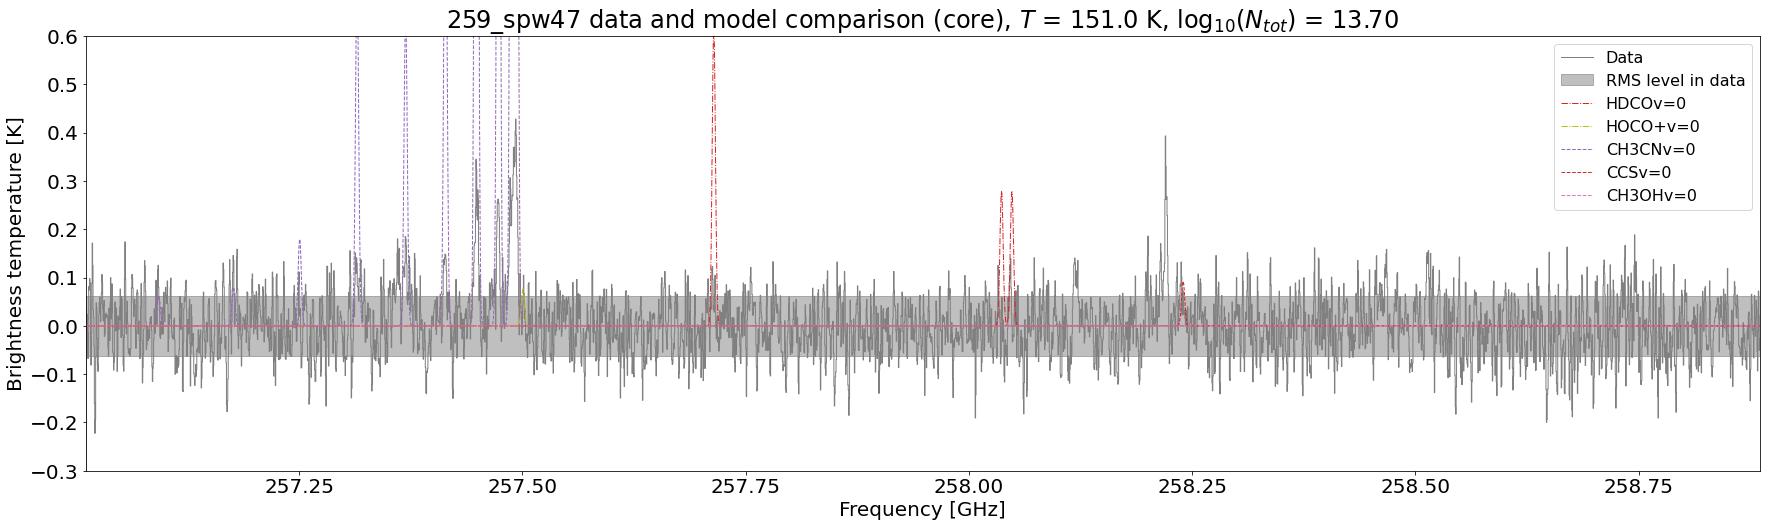

In [28]:
smoothed_cube = import_and_smooth_cube(freq_spw)
spectrum = extract_spectrum(smoothed_cube)
spectrum_contsub = contsub_spectrum(spectrum)
# Tell XCLASS where to look for the molfit files (which you must set up beforehand)
MolfitsFileNames = glob.glob(LocalPath + 'individuals/*.molfit')
modeldata_all, transenergies_all = generate_multiple_models(smoothed_cube, spectrum, MolfitsFileNames)
plot_spectra(spectrum_contsub, modeldata_all, transenergies_all, MolfitsFileNames, 'core')

***** Warning! HCNv=0 was not modeled! *****
***** Warning! HCO+v=0 was not modeled! *****
***** Warning! 13COv=0 was not modeled! *****
***** Warning! CCCSv=0 was not modeled! *****
***** Warning! NH3v=0 was not modeled! *****
***** Warning! HNCv=0 was not modeled! *****
***** Warning! NH2Dv=0 was not modeled! *****
***** Warning! HNCOv=0 was not modeled! *****
***** Warning! N2H+v=0 was not modeled! *****
***** Warning! CCHv=0 was not modeled! *****
***** Warning! HC3Nv=0 was not modeled! *****
***** Warning! COv=0 was not modeled! *****
***** Warning! OCSv=0 was not modeled! *****
***** Warning! H2CSv=0 was not modeled! *****


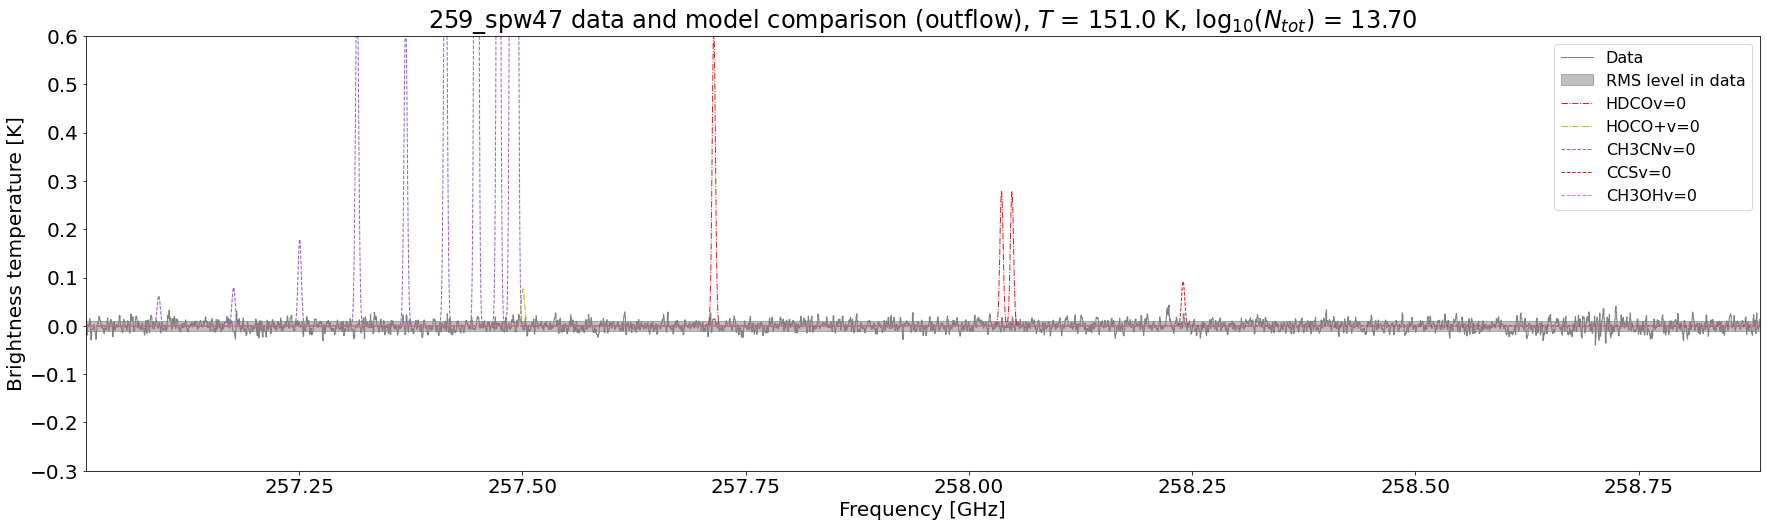

In [29]:
smoothed_cube = import_and_smooth_cube(freq_spw)
spectrum = mean_spectrum(smoothed_cube)
spectrum_contsub = contsub_spectrum(spectrum)
# Tell XCLASS where to look for the molfit files (which you must set up beforehand)
MolfitsFileNames = glob.glob(LocalPath + 'individuals/*.molfit')
modeldata_all, transenergies_all = generate_multiple_models(smoothed_cube, spectrum, MolfitsFileNames)
plot_spectra(spectrum_contsub, modeldata_all, transenergies_all, MolfitsFileNames, 'outflow')